In [23]:
# Indiana University Applied Machine Learning, Spring 2017
# Laura Kahn Programming Assignment 1
# March 21, 2017
# Code to compare the performance of Logistic Regression, Naive Bayes, Decision Tree and Nearest Neighbor on
#1996 adult income from Census data- want to predict whether a person makes more than $50,000 a year in income.

# Code adapted from https://jasdumas.github.io/2016-05-04-RF-in-python/ 

#import libraries: dataframe manipulation, machine learning, os tools


from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import os
import csv
import matplotlib.pylab as plt
import scipy.stats as stats
import sklearn

#Import machine learning classifiers 
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.cross_validation import train_test_split

import sklearn.metrics
from sklearn.metrics import classification_report

 # Feature Importance
from sklearn import datasets

In [24]:
#Change working directory to be the same as where the data set is located
os.chdir("C:/Users/lkahn/Documents/526-AppliedMachineLearning")

In [25]:
#Load the data
data = pd.read_csv("adult.csv")
#Delete rows with no values or ?
data_clean = data.dropna()

In [26]:
#Get summary statistics for the first five rows
data_clean.head(n=5)

,Age,Workclass,FnlWgt,Education,Education1,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours per week,Native-country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [27]:
#data types for each feature/variable
data_clean.dtypes 

Age                int64
Workclass         object
FnlWgt             int64
Education         object
Education1         int64
Marital-status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital-gain       int64
Capital-loss       int64
Hours per week     int64
Native-country    object
Income            object
dtype: object

In [28]:
#Get summary statistics including mean, standard deviation, quartiles
data_clean.describe()

,Age,FnlWgt,Education1,Capital-gain,Capital-loss,Hours per week
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,189778.366512,10.080679,1077.648844,87.303830,40.437456
std,13.640433,105549.977697,2.572720,7385.292085,402.960219,12.347429
min,17.000000,12285.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,117827.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,178356.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,237051.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,1484705.000000,16.000000,99999.000000,4356.000000,99.000000


In [29]:
#Data Exploration
#Note we are using prior knowledge that Education affects income in making this our target feature of the classifier
data_clean.groupby('Education1').mean()

,Age,FnlWgt,Capital-gain,Capital-loss,Hours per week
Education1,,,,,
1,42.764706,235889.372549,898.392157,66.490196,36.647059
2,46.142857,239303.000000,125.875000,48.327381,38.255952
3,42.885886,232448.333333,176.021021,68.252252,38.897898
4,48.445820,188079.171827,233.939628,65.668731,39.366873
5,41.060311,202485.066148,342.089494,28.998054,38.044747
6,37.429796,196832.465166,404.574491,56.845659,37.052519
7,32.355745,194928.077447,215.097872,50.079149,33.925957
8,32.000000,199097.508083,284.087760,32.337182,35.780600
9,38.974479,189538.739739,576.800114,70.466622,40.575374


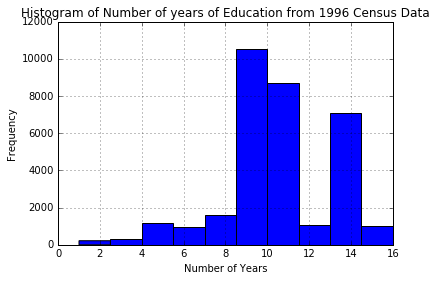

In [33]:
#Data Exploration using matplotlib
%matplotlib inline
#histogram of Education-num
data_clean.Education1.hist()
plt.title('Histogram of Number of years of Education from 1996 Census Data')
plt.xlabel('Number of Years')
plt.ylabel('Frequency')

In [34]:
# Split into training and testing sets
# Specifying predictor x variables (#We assume each column is a separate variable)

predictors = data_clean[["Age", "Workclass", "FnlWgt", "Education", "Education1",
"Marital-status", "Occupation", "Relationship", "Race","Sex", "Capital-gain", "Capital-loss", "Hours per week",
"Native-country"]]

In [35]:
#Establish y variable income >$50,000
targets = data_clean.Income

In [36]:
#We will use a test-train split of 60/40 for our model
pred_train, pred_test, tar_train, tar_test  = train_test_split(predictors, targets, test_size=.4)

In [37]:
#Training set shape and dimensions
pred_train.shape
tar_train.shape

(19536,)

In [38]:
#Test set shape & dimensions
pred_test.shape
tar_test.shape

(13025,)

In [40]:
#Build a Logistic Regression model from the training data
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

model = LogisticRegression()

#Set X to be the variable education that affects income >$50K
#Code snippets adapted from: http://nbviewer.jupyter.org/gist/justmarkham/6d5c061ca5aee67c4316471f8c2ae976

X = 'Education1'
#Convert Education1 from str to float


#Need to flatten y into a 1-D array
y = 'Income'

#Fit the model
model = model.fit(X,y)

#Prediction score of the model
model.score(X,y)

#Confusion matrix / misclassification likelihood

#Print results

ValueError: could not convert string to float: 'Education1'